In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

In [2]:
df = pd.read_pickle('FINAL2')

In [3]:
df.shape

(189305, 32)

In [4]:
df['Origin'].unique() 

array(['SFO', 'SEA', 'PHX', 'BNA', 'STL', 'CMH', 'LGA', 'JFK', 'HNL',
       'IAH'], dtype=object)

In [5]:
df2 = df.copy()
df2 = df2[(df2['Origin'] != 'HNL') & (df2['Origin'] != 'IAH') & (df2['Origin'] != 'JFK')]



In [6]:
df.sample(10)

,Origin,Date,Carrier Code,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),...,Avg_Humidity,Min_Humid,Max_Wind,Avg_Wind,Min_Wind,Max_Pressure,Avg_Pressure,Min_Pressure,Num Gates,Cert_Date
148715,LGA,10/11/2018,WN,N919WN,ATL,20:30,21:18,48.0,21:32,14.0,...,86.2,79,17,8.9,0,29.9,29.7,29.5,72,04/29/2008
114743,PHX,06/16/2018,WN,N7712G,ATL,06:00,05:53,-7.0,06:02,9.0,...,68.0,56,14,9.2,3,28.6,28.6,28.5,116,05/13/2005
156431,PHX,04/05/2018,WN,N8326F,MDW,09:00,08:59,-1.0,09:13,14.0,...,19.6,10,13,6.5,0,28.8,28.7,28.6,116,11/21/2012
37646,BNA,01/02/2018,UA,N460UA,IAH,06:23,07:11,48.0,07:22,11.0,...,50.3,28,9,4.8,0,30.1,29.9,29.7,42,07/05/2000
53099,SFO,06/15/2018,UA,N33284,PDX,10:40,10:42,2.0,11:30,48.0,...,64.1,56,22,12.7,3,29.8,29.8,29.7,115,03/26/2004
166355,PHX,10/27/2018,WN,N283WN,OKC,12:00,11:59,-1.0,12:09,10.0,...,39.3,16,9,3.8,0,28.9,28.8,28.7,116,07/16/2007
9475,SFO,06/19/2018,UA,N33132,BOS,12:20,12:16,-4.0,12:45,29.0,...,72.8,61,28,14.5,6,30.1,30.0,30.0,115,07/29/1998
183111,IAH,10/12/2018,UA,N13720,CLE,14:35,14:28,-7.0,14:44,16.0,...,80.1,60,14,8.2,3,29.9,29.8,29.8,130,02/25/1999
124506,JFK,06/22/2018,AA,N963NN,LAS,18:30,18:28,-2.0,19:00,32.0,...,84.5,68,18,11.4,5,30.0,30.0,29.9,128,12/21/2014
101800,SFO,10/18/2018,WN,N8540V,LAS,11:05,12:05,60.0,12:26,21.0,...,80.8,56,23,9.3,0,30.1,30.1,30.0,115,06/26/2017


In [7]:
def get_daypart(time):
    
    early1 = datetime.datetime.strptime("05:00", '%H:%M')
    early2 = datetime.datetime.strptime("08:00", '%H:%M')
    
    morn1 = datetime.datetime.strptime("08:00", '%H:%M')
    morn2 = datetime.datetime.strptime("12:00", '%H:%M')
    
    after1 = datetime.datetime.strptime("12:00", '%H:%M')
    after2 = datetime.datetime.strptime("17:00", '%H:%M')
    
    even1 = datetime.datetime.strptime("17:00", '%H:%M')
    even2 = datetime.datetime.strptime("21:00", '%H:%M')
    
    night1 = datetime.datetime.strptime("21:00", '%H:%M')
    night2 = datetime.datetime.strptime("05:00", '%H:%M')
    
    if time.time() >= early1.time() and time.time() < early2.time():
        return 'Early Morning'

    elif time.time() >= morn1.time() and time.time() < morn2.time():
        return 'Morning'
    
    elif time.time() >= after1.time() and time.time() < after2.time():
        return 'Afternoon'
        
    elif time.time() >= even1.time() and time.time() < even2.time():
        return 'Evening'
    
    elif time.time() >= night1.time() or time.time() < night2.time():
        return 'Night'

    
def get_day(date):
    num = date.to_pydatetime().weekday()
    day_dict = {0 : 'Mon', 1 : 'Tues', 2 : 'Wed', 3 : 'Thurs', 4 : 'Fri', 5 : 'Sat', 6 : 'Sun'}
    return day_dict[num]


def get_month(date):
    month_dict = {1 : 'Jan', 4 : 'Apr', 6 : 'Jun', 10 : 'Oct'}
    num = date.to_pydatetime().month
    return month_dict[num]

In [8]:
## Feature Engineering : Converting  columns to proper datatypes and creating new features

df['Actual departure time'] = df['Actual departure time' ].str.replace('24', '00')

df = df[df['Cert_Date'] != 'Aircraft Description']
df = df[df['Cert_Date'] != 'None']

df['Scheduled departure time'] = df['Date'] + ' ' + df['Scheduled departure time'] 
df['Actual departure time'] = df['Date'] + ' ' + df['Actual departure time']

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

df['Scheduled departure time'] = pd.to_datetime(df['Scheduled departure time'], format="%m/%d/%Y %H:%M")
df['Actual departure time'] = pd.to_datetime(df['Actual departure time'], format="%m/%d/%Y %H:%M") 

df['Cert_Date'] = pd.to_datetime(df['Cert_Date'], format='%m/%d/%Y')

df['Age'] = (df['Date'] - df['Cert_Date']).dt.days

df['DayOfWeek'] = df['Date'].apply(lambda row: get_day(row))
df['Month'] = df['Date'].apply(lambda row: get_month(row))

df['DayPart'] = df['Actual departure time'].apply(lambda row: get_daypart(row))

In [9]:
df.head()   

,Origin,Date,Carrier Code,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),...,Min_Wind,Max_Pressure,Avg_Pressure,Min_Pressure,Num Gates,Cert_Date,Age,DayOfWeek,Month,DayPart
0,SFO,2018-01-01,WN,N8651A,MDW,2018-01-01 05:15:00,2018-01-01 05:15:00,0.0,05:28,13.0,...,0,30.2,30.2,30.1,115,2014-10-16,1173.0,Mon,Jan,Early Morning
1,SFO,2018-04-08,WN,N8651A,PDX,2018-04-08 20:30:00,2018-04-08 21:17:00,47.0,21:44,27.0,...,0,30.2,30.2,30.1,115,2014-10-16,1270.0,Sun,Apr,Night
2,SFO,2018-06-01,WN,N8651A,PDX,2018-06-01 06:20:00,2018-06-01 06:18:00,-2.0,06:49,31.0,...,0,30.1,30.0,30.0,115,2014-10-16,1324.0,Fri,Jun,Early Morning
3,SFO,2018-06-02,WN,N8651A,PHX,2018-06-02 11:25:00,2018-06-02 11:23:00,-2.0,11:33,10.0,...,0,30.0,29.9,29.9,115,2014-10-16,1325.0,Sat,Jun,Morning
4,SFO,2018-06-18,WN,N8651A,MDW,2018-06-18 09:25:00,2018-06-18 09:00:00,-1.0,09:39,15.0,...,0,30.1,30.0,30.0,115,2014-10-16,1341.0,Mon,Jun,Morning


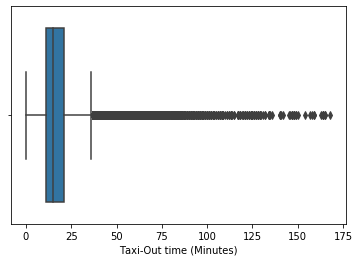

In [10]:
ax = sns.boxplot(x=df["Taxi-Out time (Minutes)"])

In [11]:
ax.get_figure().savefig("first_box.png", dpi=400)

In [12]:
Q1 = df["Taxi-Out time (Minutes)"].quantile(0.25)
Q3 = df["Taxi-Out time (Minutes)"].quantile(0.75)
IQR = Q3 - Q1

bound = Q3 + 1.5 * IQR
print(bound)

36.0


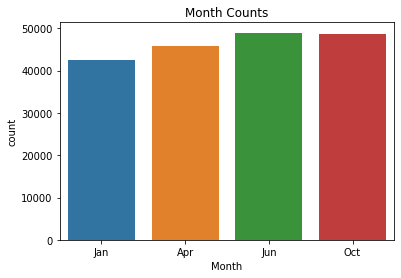

In [13]:
ax = sns.countplot(x="Month", data=df)
ax.set_title('Month Counts');

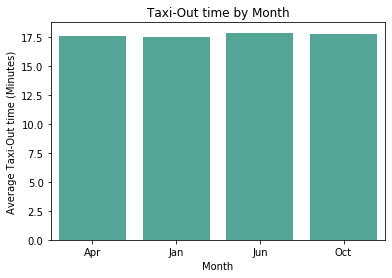

In [14]:
month_grouped = df.groupby(['Month'])['Taxi-Out time (Minutes)'].mean()

month_grouped = month_grouped.reset_index()

ax = sns.barplot(x='Month', y='Taxi-Out time (Minutes)', data=month_grouped, color='#45B39D');

ax.set_title('Taxi-Out time by Month');
ax.set_ylabel('Average Taxi-Out time (Minutes)')
ax.get_figure().savefig("months.png", dpi=400)

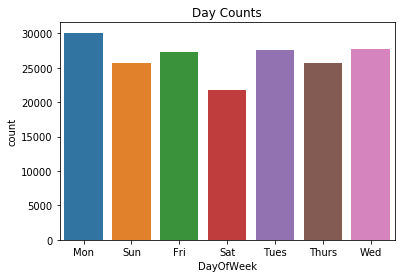

In [15]:
ax = sns.countplot(x="DayOfWeek", data=df)
ax.set_title('Day Counts');

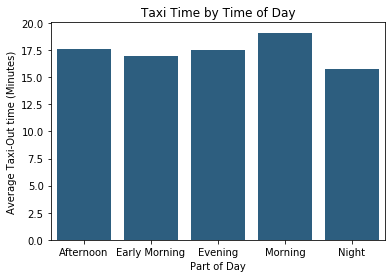

In [16]:
week_grouped = df.groupby(['DayPart'])['Taxi-Out time (Minutes)'].mean()

week_grouped = week_grouped.reset_index()

ax = sns.barplot(x='DayPart', y='Taxi-Out time (Minutes)', data=week_grouped, color='#1F618D');

ax.set_title('Taxi Time by Time of Day');
ax.set_xlabel('Part of Day')
ax.set_ylabel('Average Taxi-Out time (Minutes)')
ax.get_figure().savefig("daypart.png", dpi=400)

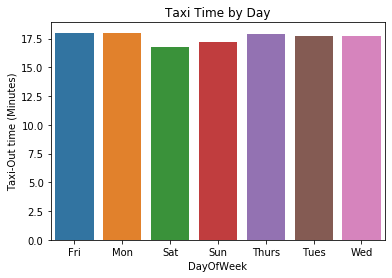

In [17]:
week_grouped = df.groupby(['DayOfWeek'])['Taxi-Out time (Minutes)'].mean()

week_grouped = week_grouped.reset_index()

ax = sns.barplot(x='DayOfWeek', y='Taxi-Out time (Minutes)', data=week_grouped);

ax.set_title('Taxi Time by Day');

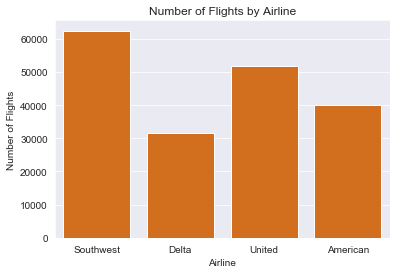

In [18]:
## Check flight distribution by airline
line_names = ['Southwest', 'Delta', 'United', 'American']
sns.set_style('darkgrid')
df['Carrier Code'].value_counts()
ax = sns.countplot(x="Carrier Code", data=df, color='#EF6C00')
ax.set_title('Number of Flights by Airline');
ax.set_xticklabels(line_names)
ax.set_xlabel('Airline')
ax.set_ylabel('Number of Flights')
ax.get_figure().savefig("airlinecounts.png", dpi=400)

In [1]:
airline_grouped = df.groupby(['Carrier Code'])['Taxi-Out time (Minutes)'].mean()

airline_grouped = airline_grouped.reset_index()
orderl = ['WN', 'DL', 'UA', 'AA']
ax = sns.barplot(x='Carrier Code', y='Taxi-Out time (Minutes)', order=orderl, data=airline_grouped, color='#1E8449');
ax.set_xticklabels(line_names)
ax.set_xlabel('Airline')
ax.set_ylabel('Average Taxi-Out time (Minutes)')
ax.set_title('Average Taxi Time by Airline');
ax.get_figure().savefig("airlinetimes.png", dpi=400)

NameError: name 'df' is not defined

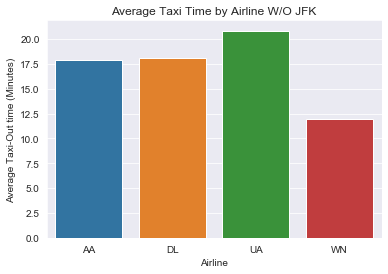

In [20]:
df2 = df.copy()
df2 = df2[(df2['Origin'] != 'JFK') & (df2['Origin'] != 'LGA')]


airline_grouped = df2.groupby(['Carrier Code'])['Taxi-Out time (Minutes)'].mean()

airline_grouped = airline_grouped.reset_index() 

ax = sns.barplot(x='Carrier Code', y='Taxi-Out time (Minutes)', data=airline_grouped);
ax.set_ylabel('Average Taxi-Out time (Minutes)')
ax.set_xlabel('Airline')
ax.set_title('Average Taxi Time by Airline W/O JFK');

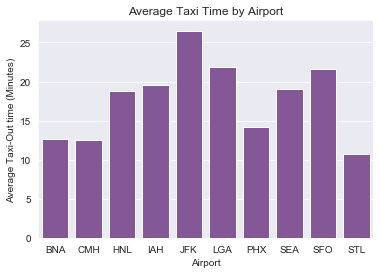

In [21]:
airport_grouped = df.groupby(['Origin'])['Taxi-Out time (Minutes)'].mean()
airport_grouped = airport_grouped.reset_index()
ax = sns.barplot(x='Origin', y='Taxi-Out time (Minutes)', data=airport_grouped, color='#884EA0')
ax.set_title('Average Taxi Time by Airport');
ax.set_ylabel('Average Taxi-Out time (Minutes)')
ax.set_xlabel('Airport')
ax.get_figure().savefig("airports.png", dpi=400)



**Grouping by airport produces results as expected. Busier airports like JFK, LGA, and SFO tend to have more traffic and naturally higher taxi-out times.**

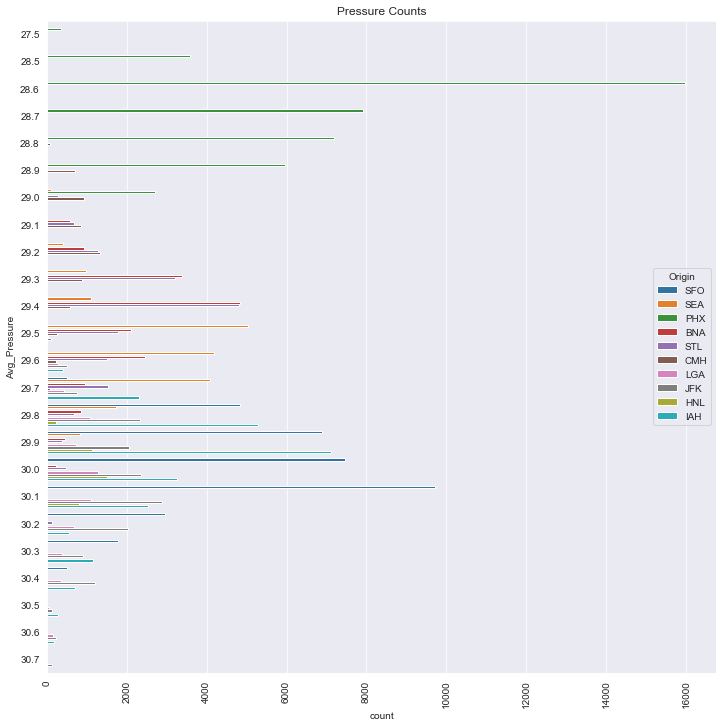

In [22]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.countplot(y="Avg_Pressure", data=df, hue='Origin')
#sns.countplot(y="Avg_Pressure", data=df)
ax.set_title('Pressure Counts');
plt.xticks(rotation=90);


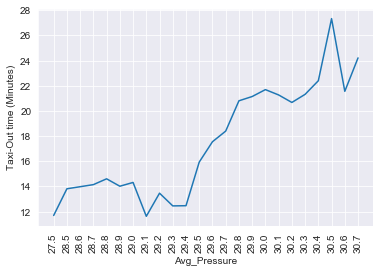

In [23]:
pressure_grouped = df.groupby(['Avg_Pressure'])['Taxi-Out time (Minutes)'].mean()
pressure_grouped = pressure_grouped.reset_index()
ax = sns.lineplot(x='Avg_Pressure', y='Taxi-Out time (Minutes)', data=pressure_grouped)
plt.xticks(rotation=90);

In [24]:
df.columns

Index(['Origin', 'Date', 'Carrier Code', 'Tail Number', 'Destination Airport',
       'Scheduled departure time', 'Actual departure time',
       'Departure delay (Minutes)', 'Wheels-off time',
       'Taxi-Out time (Minutes)', 'Delay Carrier (Minutes)',
       'Delay Weather (Minutes)', 'Delay National Aviation System (Minutes)',
       'Delay Security (Minutes)', 'Delay Late Aircraft Arrival (Minutes)',
       'Max_Temp', 'Avg_Temp', 'Min_Temp', 'Max_Dew', 'Avg_DewPoint',
       'Min_Dew', 'Max_Humid', 'Avg_Humidity', 'Min_Humid', 'Max_Wind',
       'Avg_Wind', 'Min_Wind', 'Max_Pressure', 'Avg_Pressure', 'Min_Pressure',
       'Num Gates', 'Cert_Date', 'Age', 'DayOfWeek', 'Month', 'DayPart'],
      dtype='object')

In [25]:
df = pd.get_dummies(data=df, columns=['Origin', 'Carrier Code', 'DayPart' , 'DayOfWeek', 'Month'], drop_first=True)

In [26]:
df.columns

Index(['Date', 'Tail Number', 'Destination Airport',
       'Scheduled departure time', 'Actual departure time',
       'Departure delay (Minutes)', 'Wheels-off time',
       'Taxi-Out time (Minutes)', 'Delay Carrier (Minutes)',
       'Delay Weather (Minutes)', 'Delay National Aviation System (Minutes)',
       'Delay Security (Minutes)', 'Delay Late Aircraft Arrival (Minutes)',
       'Max_Temp', 'Avg_Temp', 'Min_Temp', 'Max_Dew', 'Avg_DewPoint',
       'Min_Dew', 'Max_Humid', 'Avg_Humidity', 'Min_Humid', 'Max_Wind',
       'Avg_Wind', 'Min_Wind', 'Max_Pressure', 'Avg_Pressure', 'Min_Pressure',
       'Num Gates', 'Cert_Date', 'Age', 'Origin_CMH', 'Origin_HNL',
       'Origin_IAH', 'Origin_JFK', 'Origin_LGA', 'Origin_PHX', 'Origin_SEA',
       'Origin_SFO', 'Origin_STL', 'Carrier Code_DL', 'Carrier Code_UA',
       'Carrier Code_WN', 'DayPart_Early Morning', 'DayPart_Evening',
       'DayPart_Morning', 'DayPart_Night', 'DayOfWeek_Mon', 'DayOfWeek_Sat',
       'DayOfWeek_Sun', 'DayOfW

In [27]:
numeric_cols = ['Origin_CMH', 'Origin_HNL','Origin_IAH', 'Origin_JFK', 'Origin_LGA',
                'Origin_PHX', 'Origin_SEA', 'Origin_SFO', 'Origin_STL', 'Carrier Code_DL', 'Carrier Code_UA','Carrier Code_WN', 
                'DayPart_Early Morning', 'DayPart_Morning','DayPart_Evening', 'DayPart_Night', 'Departure delay (Minutes)', 'Taxi-Out time (Minutes)',
                'Delay Weather (Minutes)', 'Delay National Aviation System (Minutes)', 'Delay Carrier (Minutes)',
                'Avg_Temp', 'Avg_Wind']
               #'DayOfWeek_Mon', 'DayOfWeek_Sat', 'DayOfWeek_Sun','DayOfWeek_Thurs', 'DayOfWeek_Tues', 'DayOfWeek_Wed'] 

In [28]:
only_num = df[numeric_cols].copy()
only_num = only_num.apply(pd.to_numeric)
only_num = only_num.dropna(how='any')
only_num = only_num[only_num['Departure delay (Minutes)'] <= 60] 
only_num = only_num[only_num['Taxi-Out time (Minutes)'] > 0] 
only_num = only_num[only_num['Taxi-Out time (Minutes)'] <= 60]

In [29]:
only_num2 = df[numeric_cols].copy()
only_num2 = only_num2.apply(pd.to_numeric)
only_num2 = only_num2.dropna(how='any')
only_num2 = only_num2[only_num2['Departure delay (Minutes)'] <= 60] 
only_num2 = only_num2[only_num2['Taxi-Out time (Minutes)'] >= 5] 
only_num2 = only_num2[only_num2['Taxi-Out time (Minutes)'] <= 30]

only_num2 = only_num2[only_num2['Delay Weather (Minutes)'] < 30]
only_num2 = only_num2[only_num2['Delay Carrier (Minutes)'] < 30]
only_num2 = only_num2[only_num2['Delay National Aviation System (Minutes)'] < 30]
#only_num2 = only_num2[only_num2['Avg_Pressure'] <= 30.4]

only_num2['Departure delay (Minutes)'] = only_num2['Departure delay (Minutes)'].astype(int)
only_num2['Taxi-Out time (Minutes)'] = only_num2['Taxi-Out time (Minutes)'].astype(int)                  
only_num2['Delay Weather (Minutes)'] = only_num2['Delay Weather (Minutes)'].astype(int)                     
only_num2['Delay National Aviation System (Minutes)'] = only_num2['Delay National Aviation System (Minutes)'].astype(int)    
only_num2['Delay Carrier (Minutes)'] = only_num2['Delay Carrier (Minutes)'].astype(int)                                        
#only_num2['Delay Late Aircraft Arrival (Minutes)'] = only_num2['Delay Late Aircraft Arrival (Minutes)'].astype(int)  



In [30]:
only_num2.describe() 

,Origin_CMH,Origin_HNL,Origin_IAH,Origin_JFK,Origin_LGA,Origin_PHX,Origin_SEA,Origin_SFO,Origin_STL,Carrier Code_DL,...,DayPart_Morning,DayPart_Evening,DayPart_Night,Departure delay (Minutes),Taxi-Out time (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Carrier (Minutes),Avg_Temp,Avg_Wind
count,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,...,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.00000,157546.000000,157546.000000,157546.000000
mean,0.033552,0.021784,0.126725,0.066457,0.030537,0.251882,0.102002,0.173752,0.097375,0.161553,...,0.257969,0.200830,0.099438,1.916900,15.494199,0.026627,0.53811,0.605645,63.313647,8.536796
std,0.180074,0.145978,0.332666,0.249080,0.172060,0.434095,0.302652,0.378898,0.296468,0.368041,...,0.437518,0.400623,0.299250,11.810659,5.818069,0.727743,3.02511,3.164874,16.491188,3.602446
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-22.000000,5.000000,0.000000,0.00000,0.000000,1.400000,1.400000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-5.000000,11.000000,0.000000,0.00000,0.000000,53.300000,5.800000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-2.000000,15.000000,0.000000,0.00000,0.000000,62.100000,8.100000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,4.000000,19.000000,0.000000,0.00000,0.000000,75.900000,10.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,60.000000,30.000000,29.000000,29.00000,29.000000,99.900000,25.100000


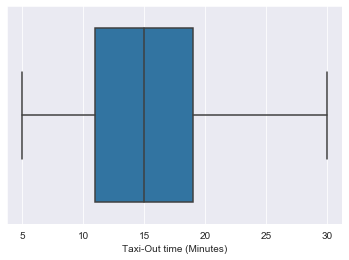

In [31]:
ax = sns.boxplot(x=only_num2["Taxi-Out time (Minutes)"])
ax.get_figure().savefig("second_box.png", dpi=400)

In [32]:
only_num2['Taxi-Out time (Minutes)'].median()

15.0

In [33]:
only_num2.dtypes

Origin_CMH                                    uint8
Origin_HNL                                    uint8
Origin_IAH                                    uint8
Origin_JFK                                    uint8
Origin_LGA                                    uint8
Origin_PHX                                    uint8
Origin_SEA                                    uint8
Origin_SFO                                    uint8
Origin_STL                                    uint8
Carrier Code_DL                               uint8
Carrier Code_UA                               uint8
Carrier Code_WN                               uint8
DayPart_Early Morning                         uint8
DayPart_Morning                               uint8
DayPart_Evening                               uint8
DayPart_Night                                 uint8
Departure delay (Minutes)                     int64
Taxi-Out time (Minutes)                       int64
Delay Weather (Minutes)                       int64
Delay Nation

(0, 25)

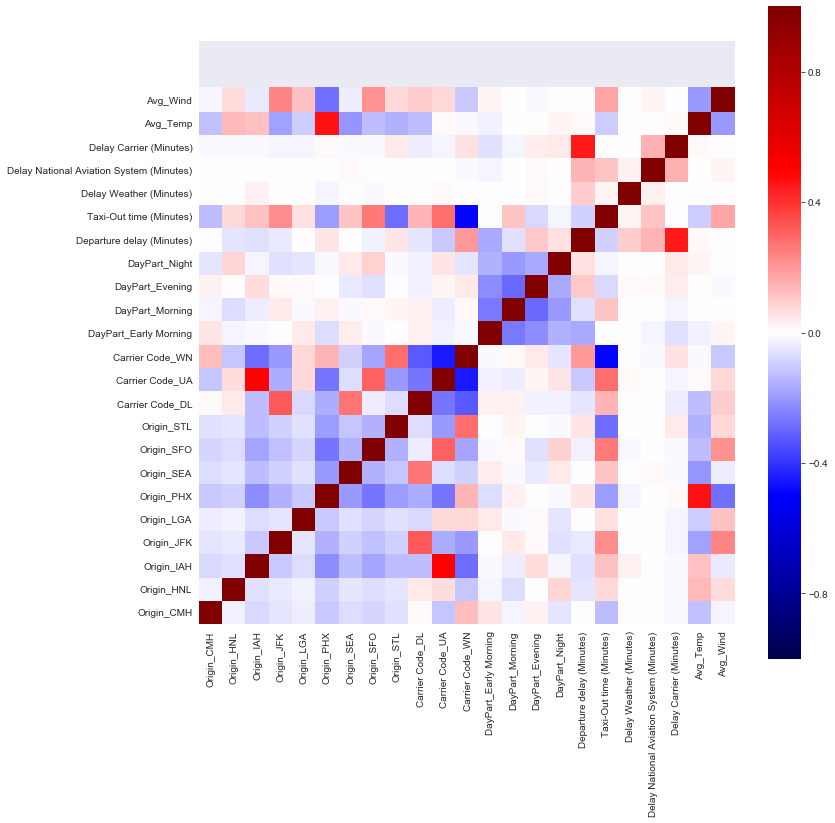

In [34]:
fig, ax = plt.subplots(figsize=(12,12)) 

sns.heatmap(only_num2.corr(), cmap="seismic", vmin=-1, vmax=1, square=True);

plt.ylim([0,25])

In [35]:
#only_num2.corr()['Avg_Pressure'].sort_values(ascending=False)

In [36]:
only_num2.corr()

,Origin_CMH,Origin_HNL,Origin_IAH,Origin_JFK,Origin_LGA,Origin_PHX,Origin_SEA,Origin_SFO,Origin_STL,Carrier Code_DL,...,DayPart_Morning,DayPart_Evening,DayPart_Night,Departure delay (Minutes),Taxi-Out time (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Carrier (Minutes),Avg_Temp,Avg_Wind
Origin_CMH,1.000000,-0.027805,-0.070978,-0.049713,-0.033069,-0.108115,-0.062797,-0.085444,-0.061198,0.008431,...,-0.020433,0.023880,-0.049664,-0.002632,-0.125880,0.002531,0.001661,-0.009160,-0.120620,-0.016038
Origin_HNL,-0.027805,1.000000,-0.056847,-0.039816,-0.026485,-0.086590,-0.050294,-0.068433,-0.049014,0.041652,...,-0.066025,0.003880,0.081621,-0.048670,0.075497,-0.004086,0.003984,-0.008952,0.135156,0.067175
Origin_IAH,-0.070978,-0.056847,1.000000,-0.101638,-0.067609,-0.221039,-0.128387,-0.174689,-0.125119,-0.125844,...,-0.037084,0.064936,-0.022142,-0.058143,0.118391,0.026989,-0.001882,-0.014938,0.119803,-0.044620
Origin_JFK,-0.049713,-0.039816,-0.101638,1.000000,-0.047353,-0.154816,-0.089923,-0.122352,-0.087634,0.321937,...,0.042232,0.015349,-0.062089,-0.043869,0.225913,0.001408,0.001002,-0.021395,-0.180954,0.241879
Origin_LGA,-0.033069,-0.026485,-0.067609,-0.047353,1.000000,-0.102982,-0.059816,-0.081388,-0.058293,-0.077905,...,-0.011559,0.010664,-0.047880,0.005353,0.060556,0.001110,-0.003559,-0.019428,-0.100498,0.118717
Origin_PHX,-0.108115,-0.086590,-0.221039,-0.154816,-0.102982,1.000000,-0.195560,-0.266087,-0.190582,-0.159709,...,0.030814,-0.005239,-0.010309,0.054392,-0.189666,-0.015705,-0.006544,0.013838,0.464529,-0.278911
Origin_SEA,-0.062797,-0.050294,-0.128387,-0.089923,-0.059816,-0.195560,1.000000,-0.154553,-0.110697,0.266507,...,-0.012251,-0.044777,0.042614,-0.006063,0.110273,-0.005905,0.007970,-0.009534,-0.204253,-0.035301
Origin_SFO,-0.085444,-0.068433,-0.174689,-0.122352,-0.081388,-0.266087,-0.154553,1.000000,-0.150619,-0.034882,...,0.009050,-0.057518,0.087610,-0.025805,0.263028,-0.014523,-0.006010,-0.007918,-0.128821,0.212940
Origin_STL,-0.061198,-0.049014,-0.125119,-0.087634,-0.058293,-0.190582,-0.110697,-0.150619,1.000000,-0.065467,...,0.017103,-0.005608,-0.011696,0.049931,-0.286719,0.006605,0.006878,0.039742,-0.150429,0.074533
Carrier Code_DL,0.008431,0.041652,-0.125844,0.321937,-0.077905,-0.159709,0.266507,-0.034882,-0.065467,1.000000,...,0.030911,-0.028263,-0.025582,-0.054400,0.143823,0.001429,-0.006414,-0.033148,-0.128530,0.095324


In [37]:
y = only_num['Taxi-Out time (Minutes)']

X = only_num.copy()
X = X.drop(columns=['Taxi-Out time (Minutes)'])

X2 = only_num2.copy()
X2 = X2.drop(columns=['Taxi-Out time (Minutes)']) 

In [38]:
X2.dtypes

Origin_CMH                                    uint8
Origin_HNL                                    uint8
Origin_IAH                                    uint8
Origin_JFK                                    uint8
Origin_LGA                                    uint8
Origin_PHX                                    uint8
Origin_SEA                                    uint8
Origin_SFO                                    uint8
Origin_STL                                    uint8
Carrier Code_DL                               uint8
Carrier Code_UA                               uint8
Carrier Code_WN                               uint8
DayPart_Early Morning                         uint8
DayPart_Morning                               uint8
DayPart_Evening                               uint8
DayPart_Night                                 uint8
Departure delay (Minutes)                     int64
Delay Weather (Minutes)                       int64
Delay National Aviation System (Minutes)      int64
Delay Carrie

In [39]:
y.describe()

count    174265.000000
mean         17.338519
std           8.569724
min           2.000000
25%          11.000000
50%          15.000000
75%          21.000000
max          60.000000
Name: Taxi-Out time (Minutes), dtype: float64

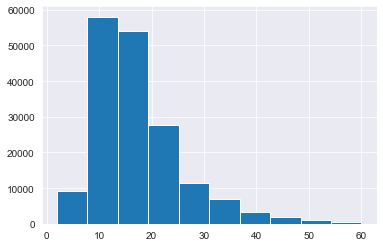

In [40]:
y.hist()

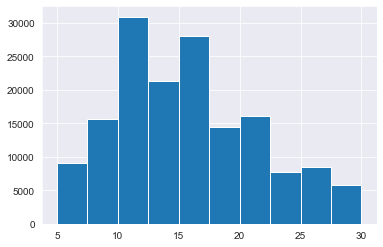

In [41]:
y2 = only_num2['Taxi-Out time (Minutes)']
y2.hist() 

In [42]:
X2.head() 

,Origin_CMH,Origin_HNL,Origin_IAH,Origin_JFK,Origin_LGA,Origin_PHX,Origin_SEA,Origin_SFO,Origin_STL,Carrier Code_DL,...,DayPart_Early Morning,DayPart_Morning,DayPart_Evening,DayPart_Night,Departure delay (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Carrier (Minutes),Avg_Temp,Avg_Wind
0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,52.1,1.7
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,47,0,6,0,57.6,12.0
3,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,-2,0,0,0,65.5,10.3
4,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,-1,0,0,0,62.4,11.4
5,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,38,0,0,0,59.6,14.5


In [43]:
np.exp(-0.26)

0.7710515858035663

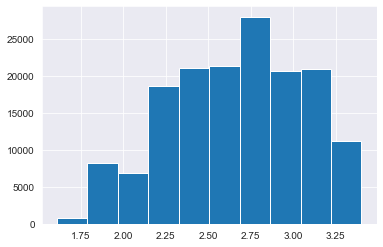

In [44]:
y2 = np.log(y2)
y2.hist()

In [105]:
X2.columns

Index(['Origin_CMH', 'Origin_HNL', 'Origin_IAH', 'Origin_JFK', 'Origin_LGA',
       'Origin_PHX', 'Origin_SEA', 'Origin_SFO', 'Origin_STL',
       'Carrier Code_DL', 'Carrier Code_UA', 'Carrier Code_WN',
       'DayPart_Early Morning', 'DayPart_Morning', 'DayPart_Evening',
       'DayPart_Night', 'Departure delay (Minutes)', 'Delay Weather (Minutes)',
       'Delay National Aviation System (Minutes)', 'Delay Carrier (Minutes)',
       'Avg_Temp', 'Avg_Wind'],
      dtype='object')

In [45]:
temp= X2.copy() 
temp.columns

Index(['Origin_CMH', 'Origin_HNL', 'Origin_IAH', 'Origin_JFK', 'Origin_LGA',
       'Origin_PHX', 'Origin_SEA', 'Origin_SFO', 'Origin_STL',
       'Carrier Code_DL', 'Carrier Code_UA', 'Carrier Code_WN',
       'DayPart_Early Morning', 'DayPart_Morning', 'DayPart_Evening',
       'DayPart_Night', 'Departure delay (Minutes)', 'Delay Weather (Minutes)',
       'Delay National Aviation System (Minutes)', 'Delay Carrier (Minutes)',
       'Avg_Temp', 'Avg_Wind'],
      dtype='object')

In [46]:

#std = StandardScaler()

#cols = temp.columns.tolist()

#def scale_cols(frame, name):
   # frame[name] = std.fit_transform(frame[[name]].values)
    
#for coln in cols:
    #scale_cols(temp, coln)
    
#temp.to_pickle('scaled_frame')
#temp.head()

In [47]:
temp['Origin_JFK'].unique()

array([0, 1], dtype=uint64)

In [48]:
X2.columns

Index(['Origin_CMH', 'Origin_HNL', 'Origin_IAH', 'Origin_JFK', 'Origin_LGA',
       'Origin_PHX', 'Origin_SEA', 'Origin_SFO', 'Origin_STL',
       'Carrier Code_DL', 'Carrier Code_UA', 'Carrier Code_WN',
       'DayPart_Early Morning', 'DayPart_Morning', 'DayPart_Evening',
       'DayPart_Night', 'Departure delay (Minutes)', 'Delay Weather (Minutes)',
       'Delay National Aviation System (Minutes)', 'Delay Carrier (Minutes)',
       'Avg_Temp', 'Avg_Wind'],
      dtype='object')

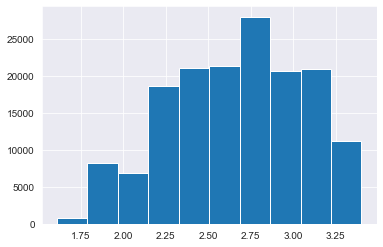

In [49]:
y2.hist()

In [50]:
np.exp(0.3305)

1.3916637864280104

In [51]:
std = StandardScaler() 
std.fit(X2.values) 
X2_scaled = std.transform(X2.values)
model2 = sm.OLS(y2, sm.add_constant(X2_scaled))

fit2 = model2.fit()
fit2.summary() 


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Taxi-Out time (Minutes)   R-squared:                       0.446
Model:                                 OLS   Adj. R-squared:                  0.446
Method:                      Least Squares   F-statistic:                     5765.
Date:                     Thu, 10 Oct 2019   Prob (F-statistic):               0.00
Time:                             23:36:41   Log-Likelihood:                -28553.
No. Observations:                   157546   AIC:                         5.715e+04
Df Residuals:                       157523   BIC:                         5.738e+04
Df Model:                               22                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6674      0.001   3649.961      0.000       2.666       2.669
x1            -0.0087      0.001    -10.381      0.000      -0.010      -0.007
x2             0.0466      0.001     54.593      0.000       0.045       0.048
x3             0.0677      0.001     54.330      0.000       0.065       0.070
x4             0.0869      0.001     83.904      0.000       0.085       0.089
x5             0.0565      0.001     65.872      0.000       0.055       0.058
x6             0.0232      0.001     17.901      0.000       0.021       0.026
x7             0.0806      0.001     76.483      0.000       0.079       0.083
x8             0.1207      0.001     95.661      0.000       0.118       0.123
x9            -0.0364      0.001    -36.263      0.000      -0.038      -0.034
x10           -0.0330      0.001    -34.646      0.000      -0.035      -0.031
x11           -0.0190      0.001    -16.487      0.000      -0.021      -0.017
x12           -0.1555      0.001   -148.738      0.000      -0.158      -0.153
x13            0.0131      0.001     15.234      0.000       0.011       0.015
x14            0.0457      0.001     51.804      0.000       0.044       0.047
x15           -0.0079      0.001     -9.134      0.000      -0.010      -0.006
x16           -0.0142      0.001    -17.375      0.000      -0.016      -0.013
x17           -0.0053      0.001     -6.213      0.000      -0.007      -0.004
x18            0.0064      0.001      8.655      0.000       0.005       0.008
x19            0.0359      0.001     48.335      0.000       0.034       0.037
x20            0.0084      0.001     10.128      0.000       0.007       0.010
x21           -0.0174      0.001    -19.544      0.000      -0.019      -0.016
x22            0.0089      0.001     10.884      0.000       0.007       0.010
==============================================================================
Omnibus:                      641.256   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              643.690
Skew:                           0.151   Prob(JB):                    1.68e-140
Kurtosis:                       2.915   Cond. No.                         4.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


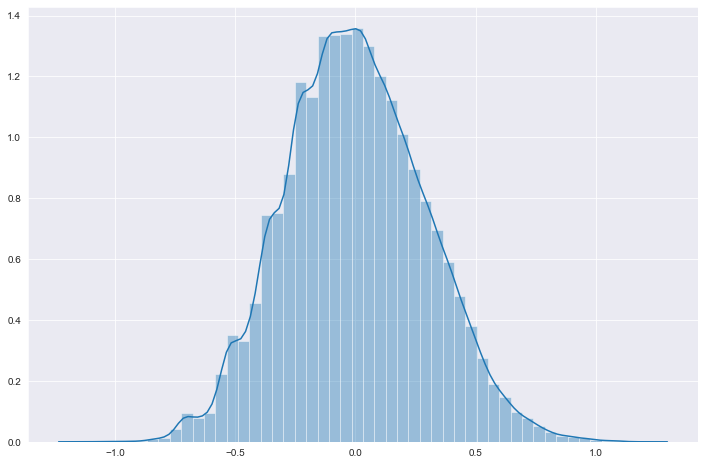

In [52]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.distplot(fit2.resid)

-1.6047457569620886e-14

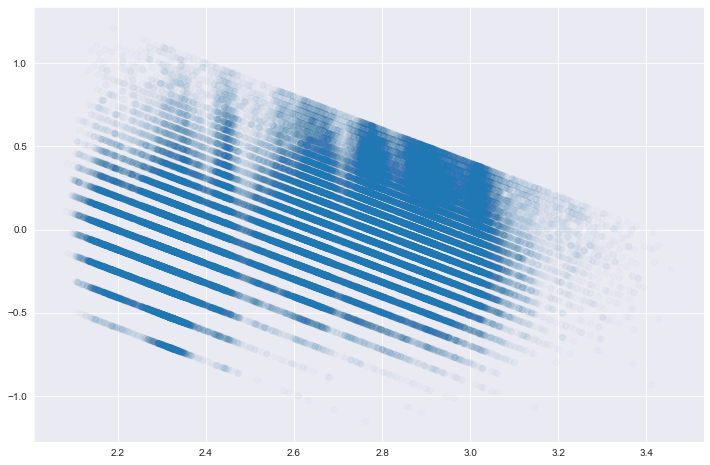

In [53]:
#fit.resid.plot(style='o', figsize=(15,10)); 
plt.figure(figsize=(12,8))
plt.scatter(fit2.predict(), fit2.resid, alpha = 0.02);

np.mean(fit2.resid)

In [54]:
X2.shape

(157546, 22)

**Bad p-values : x6, x23, x26, x28**

In [55]:
for num,name in enumerate(X2.columns.tolist()):
    print(str(num + 1) + ' ' + name)

1 Origin_CMH
2 Origin_HNL
3 Origin_IAH
4 Origin_JFK
5 Origin_LGA
6 Origin_PHX
7 Origin_SEA
8 Origin_SFO
9 Origin_STL
10 Carrier Code_DL
11 Carrier Code_UA
12 Carrier Code_WN
13 DayPart_Early Morning
14 DayPart_Morning
15 DayPart_Evening
16 DayPart_Night
17 Departure delay (Minutes)
18 Delay Weather (Minutes)
19 Delay National Aviation System (Minutes)
20 Delay Carrier (Minutes)
21 Avg_Temp
22 Avg_Wind


In [56]:
X2.describe() 

,Origin_CMH,Origin_HNL,Origin_IAH,Origin_JFK,Origin_LGA,Origin_PHX,Origin_SEA,Origin_SFO,Origin_STL,Carrier Code_DL,...,DayPart_Early Morning,DayPart_Morning,DayPart_Evening,DayPart_Night,Departure delay (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Carrier (Minutes),Avg_Temp,Avg_Wind
count,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,...,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.00000,157546.000000,157546.000000,157546.000000
mean,0.033552,0.021784,0.126725,0.066457,0.030537,0.251882,0.102002,0.173752,0.097375,0.161553,...,0.167462,0.257969,0.200830,0.099438,1.916900,0.026627,0.53811,0.605645,63.313647,8.536796
std,0.180074,0.145978,0.332666,0.249080,0.172060,0.434095,0.302652,0.378898,0.296468,0.368041,...,0.373389,0.437518,0.400623,0.299250,11.810659,0.727743,3.02511,3.164874,16.491188,3.602446
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-22.000000,0.000000,0.00000,0.000000,1.400000,1.400000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-5.000000,0.000000,0.00000,0.000000,53.300000,5.800000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.00000,0.000000,62.100000,8.100000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.00000,0.000000,75.900000,10.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,60.000000,29.000000,29.00000,29.000000,99.900000,25.100000


# Splitting Data

In [57]:
X, X_test, y, y_test = train_test_split(X2, y2, test_size=.2, random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

# Linear Regression

Lets do basic linear regression to see how metrics look. Keep in mind that the target (Taxi time) was natural logged earlier.

In [58]:
lm = LinearRegression() 

lm.fit(X_train, y_train)

print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

#Need to scale features for Ridge Regression
scaler = StandardScaler() 

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_train_scaled, y_train)

print(' ')
print(f'Ridge Regression train R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')


Linear Regression train R^2: 0.446
Linear Regression val R^2: 0.445
 
Ridge Regression train R^2: 0.446
Ridge Regression val R^2: 0.445


In [66]:
print(f'Linear Regression val R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression val R^2: 0.446


In [92]:
coef_list = list(zip(X_train.columns, np.exp(lm.coef_)))
coef_list = sorted(coef_list, key=lambda x: x[1])
coef_list

[('Carrier Code_WN', 0.7222683568393444),
 ('Origin_STL', 0.8877542960766797),
 ('Carrier Code_DL', 0.9118615914909249),
 ('DayPart_Night', 0.9483575839091576),
 ('Origin_CMH', 0.950860905972712),
 ('Carrier Code_UA', 0.9613949113799728),
 ('DayPart_Evening', 0.9802540550625779),
 ('Avg_Temp', 0.9989599229076832),
 ('Departure delay (Minutes)', 0.9995831376271812),
 ('Avg_Wind', 1.0025324497092243),
 ('Delay Carrier (Minutes)', 1.0025433358336362),
 ('Delay Weather (Minutes)', 1.0075497099206243),
 ('Delay National Aviation System (Minutes)', 1.011528487264963),
 ('DayPart_Early Morning', 1.0346841791546992),
 ('Origin_PHX', 1.0545622436281048),
 ('DayPart_Morning', 1.107711977533887),
 ('Origin_IAH', 1.222159062486494),
 ('Origin_SEA', 1.3095588241919927),
 ('Origin_SFO', 1.3728572320188412),
 ('Origin_HNL', 1.3773564028656733),
 ('Origin_LGA', 1.3817095695544606),
 ('Origin_JFK', 1.420092363769285)]

In [93]:
#list(zip(X_train.columns, scaler.inverse_transform(ridge_model.coef_)))
len(coef_list)

22

# Linear Regression Residual Plot

In [ ]:
plt.figure(figsize = (10,8))
sns.scatterplot(price_prediction, np.exp(y_test), alpha = 0.2)
sns.scatterplot(np.linspace(0,450,100), np.linspace(0,450,100))
plt.ylim([0,400]);
plt.xlim([0,450]);
plt.title('Price Prediction Vs. Actual Price (per Night)', size = 20);
plt.xlabel('Price Prediction per night (USD)', size = 15);
plt.ylabel('True Price per night (USD)', size = 15);
plt.savefig('Prediction vs Actual by Simple Regression', bbox_inches ='tight', dpi = 300)



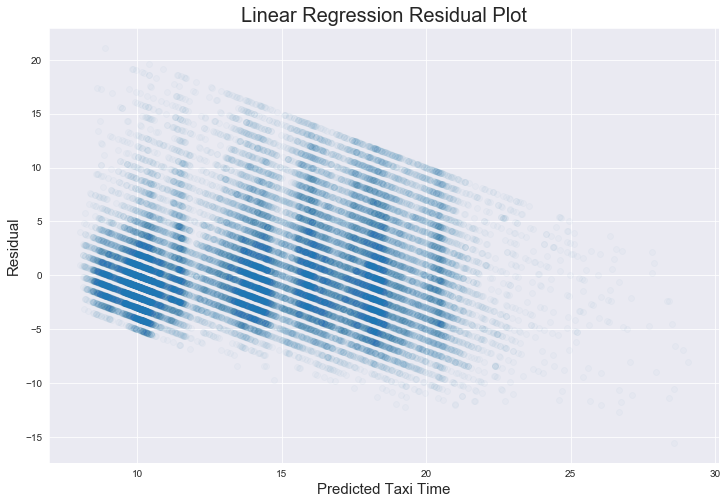

In [87]:
y_val_pred= lm.predict(X_val)

plt.figure(figsize=(12,8))
plt.scatter(np.exp(y_val_pred), np.exp(y_val) - np.exp(y_val_pred), alpha = 0.025)
plt.title('Linear Regression Residual Plot', size = 20)
plt.xlabel('Predicted Taxi Time', size = 15);
plt.ylabel('Residual', size = 15);
plt.savefig('residual_plot', bbox_inches ='tight', dpi = 400)

#plt.scatter(np.exp(y_test_pred), np.exp(y_test), alpha = 0.1)

In [88]:
np.mean(np.exp(y_val) - np.exp(y_val_pred)) 

0.673358446910471

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


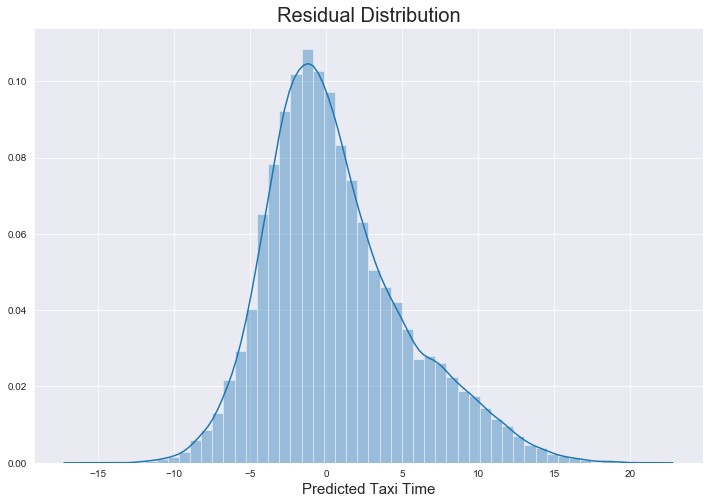

In [89]:

plt.figure(figsize=(12,8))
sns.distplot(np.exp(y_val) - np.exp(y_val_pred)) 
plt.title('Residual Distribution', size = 20)
plt.xlabel('Predicted Taxi Time', size = 15);
plt.savefig('residual_distribution', bbox_inches ='tight', dpi = 400)

In [70]:
mae_linear = np.mean(np.abs(np.exp(y_val_pred) - np.exp(y_val)))
print(mae_linear)

y_test_pred= lm.predict(X_test)
mae_linear_test = np.mean(np.abs(np.exp(y_test) - np.exp(y_test_pred)))
mae_linear_test
                          

3.553145932561809


3.5552786838638273

# Ridge Regression Residual Plot

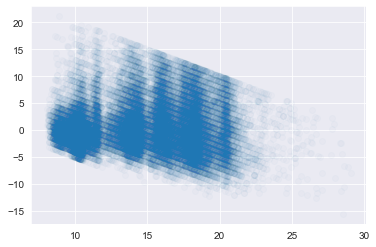

In [63]:
y_reg_val_pred = lm_reg.predict(X_val_scaled)


plt.scatter(np.exp(y_reg_val_pred), np.exp(y_val) - np.exp(y_reg_val_pred), alpha = 0.02)




In [64]:
mae_justridge = np.mean(np.abs(np.exp(y_reg_val_pred) - np.exp(y_val))) 

mae_justridge

#3.556108278581264

3.5531460542109596

In [65]:
plt.figure(figsize = (10,8))
sns.scatterplot(price_prediction, np.exp(y_test), alpha = 0.2)
sns.scatterplot(np.linspace(0,450,100), np.linspace(0,450,100))
plt.ylim([0,400]);
plt.xlim([0,450]);
plt.title('Price Prediction Vs. Actual Price (per Night)', size = 20);
plt.xlabel('Price Prediction per night (USD)', size = 15);
plt.ylabel('True Price per night (USD)', size = 15);
plt.savefig('Prediction vs Actual by Simple Regression', bbox_inches ='tight', dpi = 300)



NameError: name 'price_prediction' is not defined

<Figure size 720x576 with 0 Axes>

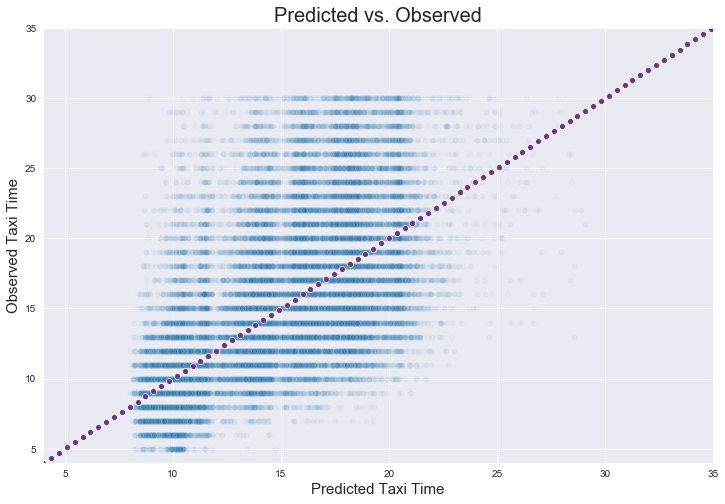

In [104]:


plt.figure(figsize = (12,8))
ax = sns.scatterplot(np.exp(y_val_pred), np.exp(y_val), alpha = 0.05)
ax = sns.scatterplot(np.linspace(4,40,100), np.linspace(4,40,100), color='#6C3483')
plt.title('Predicted vs. Observed', size=20)
plt.xlabel('Predicted Taxi Time', size=15)
plt.ylabel('Observed Taxi Time', size=15)
plt.ylim([4,35]);
plt.xlim([4,35]);

plt.savefig('comparison', bbox_inches ='tight', dpi = 400)

# Cross Validation
- Check Linear Regression and Ridge Regression scores in a more rigorous way

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state = 89)

X_scaled = scaler.fit_transform(X.values)

print("R^2 Linear:",np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print("R^2 Ridge:",np.mean(cross_val_score(lm_reg, X_scaled, y, cv=kf, scoring='r2')))

#print(" ")

#print("MAE Linear:", np.mean(cross_val_score(lr1, X, y, cv=kf, scoring='neg_mean_absolute_error'))) 
#print("MAE Ridge:", np.mean(cross_val_score(lm_reg, X_scaled, y, cv=kf, scoring='neg_mean_absolute_error'))) 

0.2333068183655735

# Polynomial Transformation

In [ ]:
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

X_poly = poly.transform(X.values)

X_poly_scaled = scaler.fit_transform(X_poly)

lm_poly = LinearRegression()

lm_poly.fit(X_train_poly, y_train)


print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

print(' ')

print("R^2 Poly Linear:",np.mean(cross_val_score(LinearRegression(), X_poly, y, cv=kf, scoring='r2')))
print("MAE Poly Linear:",np.mean(cross_val_score(LinearRegression(), X_poly, y, cv=kf, scoring='neg_mean_absolute_error')))

print("R^2 Poly Ridge:",np.mean(cross_val_score(Ridge(alpha=1), X_poly_scaled, y, cv=kf, scoring='r2')))
print("MAE Poly Ridge:",np.mean(cross_val_score(Ridge(alpha=1), X_poly_scaled, y, cv=kf, scoring='neg_mean_absolute_error')))

Using polynomial feature transformation results in an increase in R^2 by about 0.5 but the mean absolute error only changes about 0.1. In my opinion, this small increase wasn't worth the increased complexity in the model so I chose to stick with linear and ridge regression for now. Because I already carefully selected my features earlier by looking at p-vales via statsmodels summary, I am not going to use lasso.

# RidgeCV

In [ ]:
alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=kf)

ridge_model.fit(X_train_scaled, y_train)

print('RidgeCV alpha:', ridge_model.alpha_)

print(f'RidgeCV train R^2: {ridge_model.score(X_train_scaled, y_train):.3f}')
print(f'RidgeCV val R^2: {ridge_model.score(X_val_scaled, y_val):.3f}')


In [ ]:
y_rcv_val_pred = ridge_model.predict(X_val_scaled)

plt.scatter(np.exp(y_rcv_val_pred), np.exp(y_val) - np.exp(y_rcv_val_pred), alpha = 0.02)

In [ ]:
mae_rcv = np.mean(np.abs(np.exp(y_rcv_val_pred) - np.exp(y_val))) 

print('MAE for RidgeCV:', mae_rcv)

In [ ]:
ridge_model.coef_

In [ ]:
list(zip(X_train.columns, scaler.inverse_transform(ridge_model.coef_)))

In [ ]:
scaler.inverse_transform(ridge_model.coef_)

In [ ]:
alphavec = 10**np.linspace(-3,3,200)

lasso_model = LassoCV(alphas = alphavec, cv=kf)

lasso_model.fit(X_train_scaled, y_train)

print('LassoCV alpha:', lasso_model.alpha_)

print(f'LassoCV train R^2: {lasso_model.score(X_train_scaled, y_train):.3f}')
print(f'LassoCV val R^2: {lasso_model.score(X_val_scaled, y_val):.3f}')


In [ ]:
y_lcv_val_pred = lasso_model.predict(X_val_scaled)

mae_lcv = np.mean(np.abs(np.exp(y_lcv_val_pred) - np.exp(y_val))) 

print('MAE for LassoCV:', mae_lcv)